In [1]:
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

### Get train data

In [2]:
# for original data:
# load original features
trainDataFrame = pd.read_csv('./data/train.csv')

# remove constant columns
colsToRemove1 = []
for col in trainDataFrame.columns:
    if trainDataFrame[col].std() == 0:
        colsToRemove1.append(col)

trainDataFrame.drop(colsToRemove1, axis=1, inplace=True)

# remove duplicate columns
colsToRemove2 = []
columns = trainDataFrame.columns
for i in range(len(columns)-1):
    v = trainDataFrame[columns[i]].values
    for j in range(i+1,len(columns)):
        if np.array_equal(v,trainDataFrame[columns[j]].values):
            colsToRemove2.append(columns[j])

trainDataFrame.drop(colsToRemove2, axis=1, inplace=True)
#trainDataFrame.drop(['ID'], axis=1, inplace=True)

#trainLabels = trainDataFrame['TARGET']
#trainFeatures = trainDataFrame.drop(['TARGET'], axis=1)

In [3]:
print trainDataFrame.shape # 308 = 306 features + 1 label + 1 ID

(76020, 308)


In [4]:
train = trainDataFrame

### Get best 3920 features

In [37]:
trainDataFrameBest3920 = pd.read_csv('./data/trainTransformed.csv')
trainDataFrameBest3920.drop(['TARGET'], axis=1, inplace=True)

In [38]:
print trainDataFrameBest3920.shape # must be 3920 (no ID, no label)

(76020, 3920)


In [48]:
best100 = trainDataFrameBest3920.columns[:100]

In [49]:
train100 = pd.concat([trainDataFrame, trainDataFrameBest3920[best100]], axis=1)

In [64]:
print train.shape

(76020, 308)


In [45]:
print train10.shape

(76020, 318)


In [50]:
print train100.shape

(76020, 408)


### create and fit the model on original train set & best 3920 features

In [112]:
target = 'TARGET'
IDcol = 'ID'
predictors = [x for x in train.columns if x not in [target, IDcol]]

# helper func to cross validate XGB models:
def modelfit(alg, dtrain, predictors, silent=True, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    show_progress = not silent
    alg.set_params(silent=silent)
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=show_progress)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)[0:50]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return alg

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 76



Model Report
Accuracy : 0.961
AUC Score (Train): 0.875789


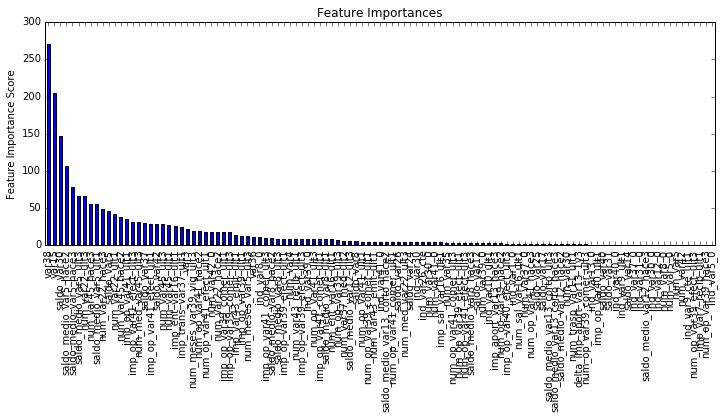

In [6]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, train, predictors)

In [9]:
param_test1 = {
 'max_depth': range(3,10,2),
 'min_child_weight': range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=76, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83797, std: 0.00855, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83786, std: 0.00859, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83786, std: 0.00857, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.83983, std: 0.00961, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.83991, std: 0.01009, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.83986, std: 0.00981, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83828, std: 0.00937, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83954, std: 0.00948, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83984, std: 0.00908, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.83666, std: 0.00958, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.83707, std: 0.00873, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83718, std: 0.00956, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 3

In [15]:
param_test2 = {
 'max_depth': [4,5,6],
 'min_child_weight': [2,3,4],
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=76, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch2.fit(train[predictors], train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.83928, std: 0.00960, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.83935, std: 0.00921, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.83946, std: 0.00972, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.83963, std: 0.00986, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.83991, std: 0.01009, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.83959, std: 0.00962, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.83973, std: 0.00981, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: 0.83913, std: 0.00931, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.84006, std: 0.00953, params: {'max_depth': 6, 'min_child_weight': 4}],
 {'max_depth': 6, 'min_child_weight': 4},
 0.84006141101456111)

In [16]:
param_test3 = {
 'max_depth': [5,6,7],
 'min_child_weight': [3,4,5],
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=76, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch3.fit(train[predictors], train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83991, std: 0.01009, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.83959, std: 0.00962, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.83986, std: 0.00981, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83913, std: 0.00931, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.84006, std: 0.00953, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.83961, std: 0.00969, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.83954, std: 0.00948, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83882, std: 0.00978, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.83984, std: 0.00908, params: {'max_depth': 7, 'min_child_weight': 5}],
 {'max_depth': 6, 'min_child_weight': 4},
 0.84006141101456111)

In [17]:
param_test4 = {
 'gamma': [i/10.0 for i in range(0,5)],
}

model = XGBClassifier( 
            learning_rate=0.1, 
            n_estimators=76, 
            max_depth=6, # use best param from prev eval
            min_child_weight=4, # use best param from prev eval
            gamma=0, 
            subsample=0.8, 
            colsample_bytree=0.8,
            objective= 'binary:logistic', 
            nthread=4, 
            scale_pos_weight=1, seed=27)
                     
gsearch4 = GridSearchCV(
                        estimator = model,
                        param_grid = param_test4, 
                        scoring='roc_auc', 
                        n_jobs=4, 
                        iid=False, cv=5)

gsearch4.fit(train[predictors], train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.84006, std: 0.00953, params: {'gamma': 0.0},
  mean: 0.83958, std: 0.00973, params: {'gamma': 0.1},
  mean: 0.83978, std: 0.00890, params: {'gamma': 0.2},
  mean: 0.83970, std: 0.00935, params: {'gamma': 0.3},
  mean: 0.83988, std: 0.00925, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.84006141101456111)

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 74



Model Report
Accuracy : 0.9611
AUC Score (Train): 0.881025


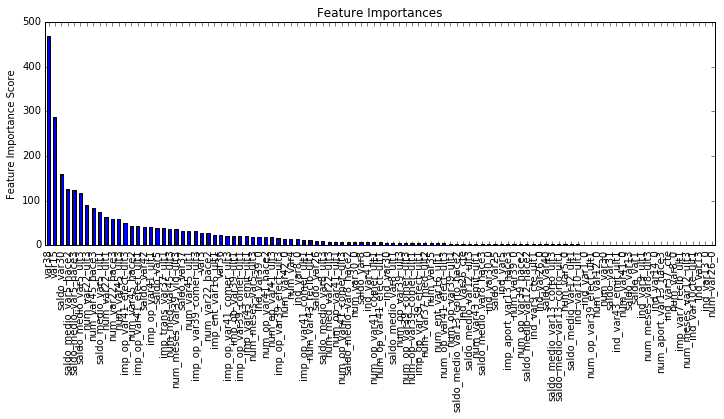

In [18]:
xgb2 = XGBClassifier( 
            learning_rate=0.1, 
            n_estimators=1000, 
            max_depth=6, 
            min_child_weight=4, 
            gamma=0, # use best param from prev eval
            subsample=0.8, 
            colsample_bytree=0.8,
            objective= 'binary:logistic', 
            nthread=4, 
            scale_pos_weight=1, seed=27)

modelfit(xgb2, train, predictors)

In [20]:
param_test5 = {
 'subsample':[i/10.0 for i in range(5,10)],
 'colsample_bytree':[i/10.0 for i in range(5,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=74, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.83895, std: 0.00893, params: {'subsample': 0.5, 'colsample_bytree': 0.5},
  mean: 0.83905, std: 0.00873, params: {'subsample': 0.6, 'colsample_bytree': 0.5},
  mean: 0.83914, std: 0.00904, params: {'subsample': 0.7, 'colsample_bytree': 0.5},
  mean: 0.83878, std: 0.00916, params: {'subsample': 0.8, 'colsample_bytree': 0.5},
  mean: 0.83956, std: 0.00920, params: {'subsample': 0.9, 'colsample_bytree': 0.5},
  mean: 0.83990, std: 0.00899, params: {'subsample': 0.5, 'colsample_bytree': 0.6},
  mean: 0.84017, std: 0.00893, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.83988, std: 0.00944, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.83957, std: 0.00958, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.84079, std: 0.00871, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.83956, std: 0.00847, params: {'subsample': 0.5, 'colsample_bytree': 0.7},
  mean: 0.83891, std: 0.00904, params: {'subsample': 0.6, 'colsample_bytree'

In [22]:
param_test5b = {
 'subsample':[0.8, 0.85, 0.9, 0.95, 1.0],
 'colsample_bytree':[0.5, 0.55, 0.6, 0.65, 0.70]
}
gsearch5b = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=74, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5b, scoring='roc_auc',n_jobs=4, iid=False, cv=5)
gsearch5b.fit(train[predictors],train[target])
gsearch5b.grid_scores_, gsearch5b.best_params_, gsearch5b.best_score_

([mean: 0.83878, std: 0.00916, params: {'subsample': 0.8, 'colsample_bytree': 0.5},
  mean: 0.83950, std: 0.00944, params: {'subsample': 0.85, 'colsample_bytree': 0.5},
  mean: 0.83956, std: 0.00920, params: {'subsample': 0.9, 'colsample_bytree': 0.5},
  mean: 0.83950, std: 0.00866, params: {'subsample': 0.95, 'colsample_bytree': 0.5},
  mean: 0.83917, std: 0.00953, params: {'subsample': 1.0, 'colsample_bytree': 0.5},
  mean: 0.83973, std: 0.00970, params: {'subsample': 0.8, 'colsample_bytree': 0.55},
  mean: 0.83979, std: 0.00920, params: {'subsample': 0.85, 'colsample_bytree': 0.55},
  mean: 0.84025, std: 0.00899, params: {'subsample': 0.9, 'colsample_bytree': 0.55},
  mean: 0.83934, std: 0.00926, params: {'subsample': 0.95, 'colsample_bytree': 0.55},
  mean: 0.83980, std: 0.00945, params: {'subsample': 1.0, 'colsample_bytree': 0.55},
  mean: 0.83957, std: 0.00958, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.84012, std: 0.00910, params: {'subsample': 0.85, 'colsamp

In [23]:
# gridsearch reg params: reg_alpha, reg_lambda
param_test6 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 10],
    'reg_lambda': [0, 0.2, 0.5, 1, 2, 5],
    
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=74, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.84001, std: 0.00874, params: {'reg_alpha': 1e-05, 'reg_lambda': 0},
  mean: 0.84042, std: 0.00868, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.2},
  mean: 0.83967, std: 0.00906, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.5},
  mean: 0.84079, std: 0.00871, params: {'reg_alpha': 1e-05, 'reg_lambda': 1},
  mean: 0.84065, std: 0.00967, params: {'reg_alpha': 1e-05, 'reg_lambda': 2},
  mean: 0.84054, std: 0.00941, params: {'reg_alpha': 1e-05, 'reg_lambda': 5},
  mean: 0.83967, std: 0.00858, params: {'reg_alpha': 0.01, 'reg_lambda': 0},
  mean: 0.84014, std: 0.00797, params: {'reg_alpha': 0.01, 'reg_lambda': 0.2},
  mean: 0.83981, std: 0.00920, params: {'reg_alpha': 0.01, 'reg_lambda': 0.5},
  mean: 0.84066, std: 0.00882, params: {'reg_alpha': 0.01, 'reg_lambda': 1},
  mean: 0.84038, std: 0.00891, params: {'reg_alpha': 0.01, 'reg_lambda': 2},
  mean: 0.84080, std: 0.00924, params: {'reg_alpha': 0.01, 'reg_lambda': 5},
  mean: 0.84002, std: 0.00906, params: {'reg_alpha': 0.1, 'reg

In [25]:
# gridsearch reg params: reg_alpha, reg_lambda
param_test6b = {
    'reg_alpha': [ 0, 0.5, 0.8, 1, 1.2, 1.5, 2 ],
    'reg_lambda': [ 4, 5, 7, 10 ],
    
}
gsearch6b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=74, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.6,
 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6b.fit(train[predictors],train[target])
gsearch6b.grid_scores_, gsearch6b.best_params_, gsearch6b.best_score_

([mean: 0.84001, std: 0.00874, params: {'reg_alpha': 1e-05, 'reg_lambda': 0},
  mean: 0.84042, std: 0.00868, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.2},
  mean: 0.83967, std: 0.00906, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.5},
  mean: 0.84079, std: 0.00871, params: {'reg_alpha': 1e-05, 'reg_lambda': 1},
  mean: 0.84065, std: 0.00967, params: {'reg_alpha': 1e-05, 'reg_lambda': 2},
  mean: 0.84054, std: 0.00941, params: {'reg_alpha': 1e-05, 'reg_lambda': 5},
  mean: 0.83967, std: 0.00858, params: {'reg_alpha': 0.01, 'reg_lambda': 0},
  mean: 0.84014, std: 0.00797, params: {'reg_alpha': 0.01, 'reg_lambda': 0.2},
  mean: 0.83981, std: 0.00920, params: {'reg_alpha': 0.01, 'reg_lambda': 0.5},
  mean: 0.84066, std: 0.00882, params: {'reg_alpha': 0.01, 'reg_lambda': 1},
  mean: 0.84038, std: 0.00891, params: {'reg_alpha': 0.01, 'reg_lambda': 2},
  mean: 0.84080, std: 0.00924, params: {'reg_alpha': 0.01, 'reg_lambda': 5},
  mean: 0.84002, std: 0.00906, params: {'reg_alpha': 0.1, 'reg

In [26]:
# gridsearch reg params: reg_alpha, reg_lambda
param_test6b = {
    'reg_alpha': [ 0.9, 1, 1.1 ],
    'reg_lambda': [ 4.5, 4.75, 5, 5.25, 5.5 ],
    
}
gsearch6b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=74, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.6,
 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6b.fit(train[predictors],train[target])
gsearch6b.grid_scores_, gsearch6b.best_params_, gsearch6b.best_score_

([mean: 0.84001, std: 0.00874, params: {'reg_alpha': 1e-05, 'reg_lambda': 0},
  mean: 0.84042, std: 0.00868, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.2},
  mean: 0.83967, std: 0.00906, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.5},
  mean: 0.84079, std: 0.00871, params: {'reg_alpha': 1e-05, 'reg_lambda': 1},
  mean: 0.84065, std: 0.00967, params: {'reg_alpha': 1e-05, 'reg_lambda': 2},
  mean: 0.84054, std: 0.00941, params: {'reg_alpha': 1e-05, 'reg_lambda': 5},
  mean: 0.83967, std: 0.00858, params: {'reg_alpha': 0.01, 'reg_lambda': 0},
  mean: 0.84014, std: 0.00797, params: {'reg_alpha': 0.01, 'reg_lambda': 0.2},
  mean: 0.83981, std: 0.00920, params: {'reg_alpha': 0.01, 'reg_lambda': 0.5},
  mean: 0.84066, std: 0.00882, params: {'reg_alpha': 0.01, 'reg_lambda': 1},
  mean: 0.84038, std: 0.00891, params: {'reg_alpha': 0.01, 'reg_lambda': 2},
  mean: 0.84080, std: 0.00924, params: {'reg_alpha': 0.01, 'reg_lambda': 5},
  mean: 0.84002, std: 0.00906, params: {'reg_alpha': 0.1, 'reg

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-auc:0.7287202+0.051806010066	cv-train-auc:0.7329446+0.0387023875935
[1]	cv-test-auc:0.7571168+0.0354097130821	cv-train-auc:0.7633598+0.0220329913212
[2]	cv-test-auc:0.7710154+0.0123697971624	cv-train-auc:0.7792964+0.0057876268228
[3]	cv-test-auc:0.7744418+0.0104528711539	cv-train-auc:0.781797+0.00544294387257
[4]	cv-test-auc:0.7783402+0.0143115882193	cv-train-auc:0.786878+0.0068491647082
[5]	cv-test-auc:0.7822556+0.015300911484	cv-train-auc:0.7916946+0.0109525508006
[6]	cv-test-auc:0.7866546+0.0124107077735	cv-train-auc:0.797022+0.0134417980345
[7]	cv-test-auc:0.7916862+0.0112135021363	cv-train-auc:0.8017058+0.0111682817192
[8]	cv-test-auc:0.7957768+0.0106506560812	cv-train-auc:0.8055116+0.00687288348803
[9]	cv-test-auc:0.7956406+0.00994543166685	cv-train-auc:0.8054874+0.00688339911962
[10]	cv-test-auc:0.7958452+0.0109064440658	cv-train-auc:0.8063134+0.00467404615296
[11]	cv-test-auc:0.794611+0.011407464188	cv-train-a


Model Report
Accuracy : 0.9609
AUC Score (Train): 0.877584


[621]	cv-test-auc:0.8402756+0.0042003649651	cv-train-auc:0.8875002+0.00075302201827
Stopping. Best iteration: 571


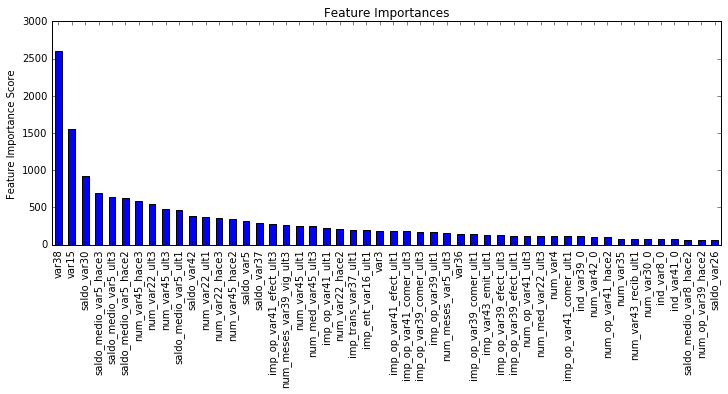

In [34]:
# reduce learning rate and CV:
xgb_model = XGBClassifier( learning_rate=0.015, n_estimators=5000,
                            max_depth=6, min_child_weight=4, gamma=0, 
                            subsample=0.9, colsample_bytree=0.6, objective= 'binary:logistic',
                            reg_alpha=1, reg_lambda=5,
                            nthread=4, scale_pos_weight=1, seed=27)

xgb_cv = modelfit(xgb_model, train, predictors, useTrainCV=True, silent=False) # cv_folds=5, early_stopping_rounds=50 

In [51]:
train100.shape

(76020, 408)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-auc:0.7287202+0.051806010066	cv-train-auc:0.7329446+0.0387023875935
[1]	cv-test-auc:0.7569274+0.0352978920084	cv-train-auc:0.7632086+0.0219735488131
[2]	cv-test-auc:0.7708712+0.0123052296102	cv-train-auc:0.7790282+0.00604796016521
[3]	cv-test-auc:0.7742828+0.0103397827908	cv-train-auc:0.781698+0.00551270956971
[4]	cv-test-auc:0.7758802+0.0110742517833	cv-train-auc:0.783602+0.00491303796037
[5]	cv-test-auc:0.7795234+0.0123253963604	cv-train-auc:0.7880328+0.0109141987411
[6]	cv-test-auc:0.78209+0.00661876039754	cv-train-auc:0.790691+0.0113637283142
[7]	cv-test-auc:0.788265+0.00726477674812	cv-train-auc:0.7965816+0.0123429710459
[8]	cv-test-auc:0.7917038+0.00796364284483	cv-train-auc:0.7998734+0.0108002682485
[9]	cv-test-auc:0.7919308+0.00796710289629	cv-train-auc:0.800376+0.0111021207524
[10]	cv-test-auc:0.7917716+0.00886976474547	cv-train-auc:0.8006472+0.0102756592664
[11]	cv-test-auc:0.7905398+0.00929002887832	cv-trai


Model Report
Accuracy : 0.9609
AUC Score (Train): 0.877492


[883]	cv-test-auc:0.8403976+0.0041105411128	cv-train-auc:0.886087+0.000800804595391
Stopping. Best iteration: 833


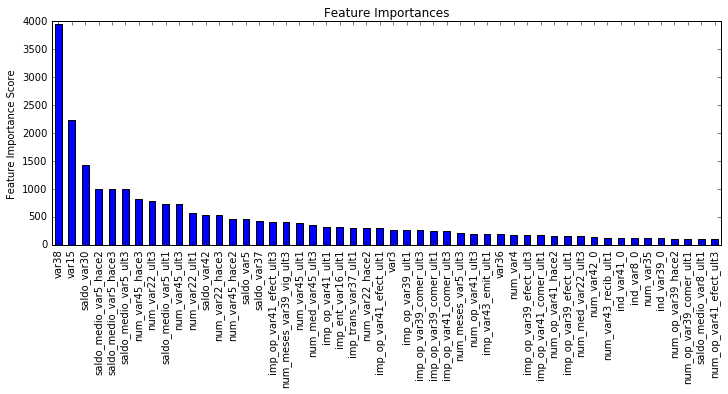

In [47]:
# check performance w orig data + [10, 50, 100] best binary features
# w best10
xgb_model = XGBClassifier( learning_rate=0.01, n_estimators=5000,
                            max_depth=6, min_child_weight=4, gamma=0, 
                            subsample=0.9, colsample_bytree=0.6, objective= 'binary:logistic',
                            reg_alpha=1, reg_lambda=5,
                            nthread=4, scale_pos_weight=1, seed=27)

xgb_cv = modelfit(xgb_model, train10, predictors, useTrainCV=True, silent=False)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-auc:0.7287202+0.051806010066	cv-train-auc:0.7329446+0.0387023875935
[1]	cv-test-auc:0.7569274+0.0352978920084	cv-train-auc:0.7632086+0.0219735488131
[2]	cv-test-auc:0.7708712+0.0123052296102	cv-train-auc:0.7790282+0.00604796016521
[3]	cv-test-auc:0.7742828+0.0103397827908	cv-train-auc:0.781698+0.00551270956971
[4]	cv-test-auc:0.7758802+0.0110742517833	cv-train-auc:0.783602+0.00491303796037
[5]	cv-test-auc:0.7795234+0.0123253963604	cv-train-auc:0.7880328+0.0109141987411
[6]	cv-test-auc:0.78209+0.00661876039754	cv-train-auc:0.790691+0.0113637283142
[7]	cv-test-auc:0.788265+0.00726477674812	cv-train-auc:0.7965816+0.0123429710459
[8]	cv-test-auc:0.7917038+0.00796364284483	cv-train-auc:0.7998734+0.0108002682485
[9]	cv-test-auc:0.7919308+0.00796710289629	cv-train-auc:0.800376+0.0111021207524
[10]	cv-test-auc:0.7917716+0.00886976474547	cv-train-auc:0.8006472+0.0102756592664
[11]	cv-test-auc:0.7905398+0.00929002887832	cv-trai


Model Report
Accuracy : 0.9609
AUC Score (Train): 0.877492


[883]	cv-test-auc:0.8403976+0.0041105411128	cv-train-auc:0.886087+0.000800804595391
Stopping. Best iteration: 833


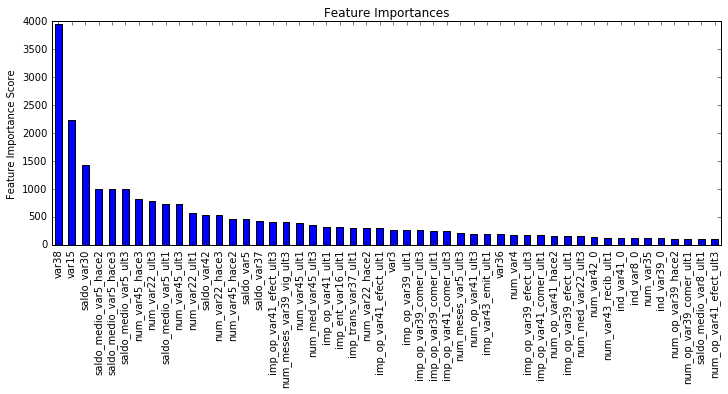

In [52]:
# check performance w orig data + [10, 50, 100] best binary features
# w best100
xgb_model = XGBClassifier( learning_rate=0.01, n_estimators=5000,
                            max_depth=6, min_child_weight=4, gamma=0, 
                            subsample=0.9, colsample_bytree=0.6, objective= 'binary:logistic',
                            reg_alpha=1, reg_lambda=5,
                            nthread=4, scale_pos_weight=1, seed=27)

xgb_cv = modelfit(xgb_model, train100, predictors, useTrainCV=True, silent=False)

In [59]:
xgb_cv.booster().get_split_value_histogram('var38')

AttributeError: 'Booster' object has no attribute 'get_split_value_histogram'

In [90]:
imps = xgb_cv.booster().get_fscore()
attrs = []
for k,v in imps.items():
    if v>400:
        attrs.append(k)

In [91]:
attrs

['saldo_medio_var5_hace3',
 'saldo_medio_var5_hace2',
 'num_var22_hace3',
 'num_var22_ult1',
 'num_var22_ult3',
 'num_var45_ult3',
 'var15',
 'num_var45_hace2',
 'num_var45_hace3',
 'imp_op_var41_efect_ult3',
 'saldo_var5',
 'var38',
 'saldo_var42',
 'saldo_medio_var5_ult1',
 'saldo_medio_var5_ult3',
 'saldo_var30',
 'saldo_var37']

## Try FeatureGenerator2

In [63]:
import sys
sys.path.insert(0, '/Users/gokhan/libs')

from Evio.FeatureGenerator import FeatureGenerator2

In [122]:
def importOrReload(module_name, *names):
    import sys

    if module_name in sys.modules:
        reload(sys.modules[module_name])
    else:
        __import__(module_name, fromlist=names)

    for name in names:
        globals()[name] = getattr(sys.modules[module_name], name)

# use instead of: from dfly_parser import parseMessages
importOrReload("Evio.FeatureGenerator", "FeatureGenerator2")

In [92]:
predictors = ['saldo_medio_var5_hace3',
 'saldo_medio_var5_hace2',
 'num_var22_hace3',
 'num_var22_ult1',
 'num_var22_ult3',
 'num_var45_ult3',
 'var15',
 'num_var45_hace2',
 'num_var45_hace3',
 'imp_op_var41_efect_ult3',
 'saldo_var5',
 'var38',
 'saldo_var42',
 'saldo_medio_var5_ult1',
 'saldo_medio_var5_ult3',
 'saldo_var30',
 'saldo_var37']

In [123]:
fg = FeatureGenerator2(train[predictors], train[target], attrs_ig_stats=attrs_ig_stats, random_state=27)

In [115]:
attrs_ig_stats = fg.attrs_ig_stats

In [118]:
attrs_ig_stats

{'delta_imp_amort_var18_1y3': {'ig_max': -18268.041872315018,
  'ig_mean': -18268.041872315018,
  'ig_std': 0.0},
 'delta_imp_amort_var34_1y3': {'ig_max': -18268.041872315018,
  'ig_mean': -18268.041872315018,
  'ig_std': 0.0},
 'delta_imp_aport_var13_1y3': {'ig_max': -18194.953462183894,
  'ig_mean': -18226.59528055289,
  'ig_std': 33.726302296416357},
 'delta_imp_aport_var17_1y3': {'ig_max': -18267.109820391106,
  'ig_mean': -18267.687715487897,
  'ig_std': 0.38892734332205497},
 'delta_imp_aport_var33_1y3': {'ig_max': -18266.818513101316,
  'ig_mean': -18267.131650839459,
  'ig_std': 0.38192969277625338},
 'delta_imp_compra_var44_1y3': {'ig_max': -18266.701984709125,
  'ig_mean': -18267.412091507969,
  'ig_std': 0.51577932177162278},
 'delta_imp_reemb_var13_1y3': {'ig_max': -18268.015189067239,
  'ig_mean': -18268.015189067239,
  'ig_std': 0.0},
 'delta_imp_reemb_var17_1y3': {'ig_max': -18268.100118913193,
  'ig_mean': -18268.110123139581,
  'ig_std': 0.010004226387536619},
 'delta_

In [124]:
fg.get_features(100)

Added feature 0:
['saldo_medio_var13_largo_hace3' 'ind_var25_0' 'num_var45_ult3'
 'imp_op_var41_efect_ult3' 'imp_op_var40_efect_ult1']
[ 0.43655651  0.71507327 -0.04083947 -1.9767458  -0.1671913 ]
-3856.73711969
Added feature 1:
['num_var5' 'ind_var7_recib_ult1']
[ 2.04007566  0.06387016]
0.063870155058
Added feature 2:
['num_var20' 'num_op_var39_ult1' 'num_op_var40_ult1'
 'delta_imp_trasp_var33_out_1y3' 'imp_trasp_var17_in_ult1']
[-0.87316286  0.70843394 -0.86142156  0.231375    0.89916463]
-2.29481425709
Added feature 3:
['num_venta_var44_ult1' 'imp_aport_var33_hace3' 'num_var14' 'saldo_var14']
[-0.59463811  0.96091596  1.84331613  1.88363599]
42.0348139443
Added feature 4:
['delta_num_venta_var44_1y3' 'saldo_var6' 'saldo_medio_var17_hace3'
 'num_var13_largo' 'num_var1_0']
[-0.21955234 -0.06513224  0.046925   -1.06428394  1.11403338]
-1.75641874823
Added feature 5:
['num_var32_0' 'saldo_var34' 'ind_var5']
[-0.80254045 -0.11378584  0.35706511]
0.357065106196
Added feature 6:
['num_apo

In [127]:
fg._features.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64')

In [130]:
print train.shape
print trn_fg100.shape

(76020, 308)
(76020, 408)


In [129]:
trn_fg100 = pd.concat([train, fg._features], axis=1)

In [131]:
predictors = [x for x in trn_fg100.columns if x not in [target, IDcol]]

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-auc:0.7491504+0.0346389045358	cv-train-auc:0.7543074+0.0355424292169
[1]	cv-test-auc:0.7683316+0.0198261495969	cv-train-auc:0.775052+0.0218148200084
[2]	cv-test-auc:0.7699978+0.0207782038146	cv-train-auc:0.7778536+0.0235274742172
[3]	cv-test-auc:0.7853816+0.0154774088607	cv-train-auc:0.7926468+0.00944228873526
[4]	cv-test-auc:0.78646+0.0161826268078	cv-train-auc:0.7941848+0.00979974782125
[5]	cv-test-auc:0.7901268+0.0157237921431	cv-train-auc:0.7986078+0.0104824408112
[6]	cv-test-auc:0.7889026+0.0116714486265	cv-train-auc:0.7970624+0.00718260038148
[7]	cv-test-auc:0.792861+0.0158866919527	cv-train-auc:0.8015332+0.00916283203819
[8]	cv-test-auc:0.7935364+0.0157767996958	cv-train-auc:0.8027614+0.00967657217407
[9]	cv-test-auc:0.7939294+0.015628160744	cv-train-auc:0.8031196+0.0093122845661
[10]	cv-test-auc:0.7941014+0.0154298934099	cv-train-auc:0.8033786+0.00941119373087
[11]	cv-test-auc:0.7950784+0.0144680846915	cv-trai


Model Report
Accuracy : 0.961
AUC Score (Train): 0.883919


Stopping. Best iteration: 750


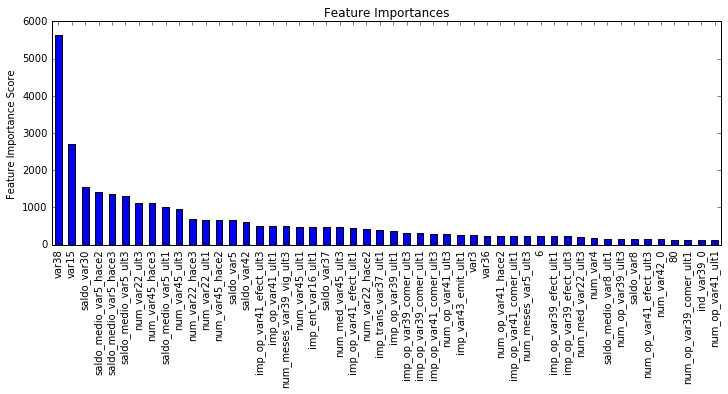

In [134]:
# check performance w orig data + 100 best fg2 features
xgb_model = XGBClassifier( learning_rate=0.01, n_estimators=5000,
                            max_depth=7, min_child_weight=3, gamma=0, 
                            subsample=0.9, colsample_bytree=0.6, objective= 'binary:logistic',
                            reg_alpha=1, reg_lambda=5,
                            nthread=4, scale_pos_weight=1, seed=27)

xgb_cv = modelfit(xgb_model, trn_fg100, predictors, useTrainCV=True, silent=False)

### Used before (initially):

In [ ]:
param = {'bst:max_depth':5, 'bst:eta':0.0202048, 'silent':1, 'objective':'binary:logistic' }
#param['nthread'] = 4
param['eval_metric'] = 'auc'
num_round = 500


dtrain = xgboost.DMatrix(X_train, label=y_train)
evallist  = [(dtrain,'train')]
clf = xgboost.train( param, dtrain, num_round, evallist )
